In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold

# model
from sklearn.ensemble import RandomForestRegressor

SEED=42

In [3]:
path = 'drive/My Drive/bigcontest2019/data/'
print(os.listdir(path + 'train'),'\n', 
      os.listdir(path + 'test'),'\n', 
#       os.listdir(path + '../metrics'),'\n', 
      os.listdir(path + '../scripts'))

['train_payment.csv', 'train_trade.csv', 'train_pledge.csv', 'train_combat.csv', 'train_label.csv', 'train_activity.csv'] 
 ['test1_activity.csv', 'test1_combat.csv', 'test2_activity.csv', 'test1_pledge.csv', 'test2_combat.csv', 'test2_trade.csv', 'test1_trade.csv', 'test1_payment.csv', 'test2_payment.csv', 'test2_pledge.csv'] 
 ["hh's work", 'model', 'explortary data', 'data merge', 'metrics']


In [0]:
train_label = pd.read_csv(path + 'train/train_label.csv')
train_activity = pd.read_csv(path + 'train/train_activity.csv')
#train_combat = pd.read_csv(path + 'train/train_combat.csv')
train_payment = pd.read_csv(path + 'train/train_payment.csv')
#train_pledge = pd.read_csv(path + 'train/train_pledge.csv')
#train_trade = pd.read_csv(path + 'train/train_trade.csv')

test1_activity = pd.read_csv(path + 'test/test1_activity.csv')
#test1_combat = pd.read_csv(path + 'test/test1_combat.csv')
test1_payment = pd.read_csv(path + 'test/test1_payment.csv')
#test1_pledge = pd.read_csv(path + 'test/test1_pledge.csv')
#test1_trade = pd.read_csv(path + 'test/test1_trade.csv')

test2_activity = pd.read_csv(path + 'test/test2_activity.csv')
#test2_combat = pd.read_csv(path + 'test/test2_combat.csv')
test2_payment = pd.read_csv(path + 'test/test2_payment.csv')
#test2_pledge = pd.read_csv(path + 'test/test2_pledge.csv')
#test2_trade = pd.read_csv(path + 'test/test2_trade.csv')

In [5]:
train_activity.sort_values(['acc_id','day']).head()

,day,acc_id,char_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
37347,1,2,233598,au,2.703457,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0
91681,2,2,233598,au,3.363522,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.149118,-1.044201,0.0
146496,3,2,233598,au,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.183447,0.451317,0.0
201273,4,2,233598,au,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.131992,-0.007230,0.0
256953,5,2,233598,au,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.135698,0.015398,0.0


In [0]:
activity_d = train_activity.drop(['server', 'char_id'], axis=1).sort_values(['acc_id','day']).reset_index(drop=True)

In [7]:
activity_d.head()

,day,acc_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,1,2,2.703457,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0
1,2,2,3.363522,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.149118,-1.044201,0.0
2,3,2,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.183447,0.451317,0.0
3,4,2,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.131992,-0.007230,0.0
4,5,2,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.135698,0.015398,0.0


In [0]:
activity_ad = activity_d.groupby(['acc_id', 'day']).sum().reset_index()

In [0]:
activity_shifted = activity_ad.groupby(['acc_id']).shift(1).fillna(0).drop('day', axis=1)
activity_shifted.head()

,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,2.703457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0
2,3.363522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.149118,-1.044201,0.0
3,3.370544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.183447,0.451317,0.0
4,3.370544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.131992,-0.007230,0.0


In [0]:
activity_char = activity_ad[['acc_id', 'day']].copy()
activity_diff = pd.concat([activity_char, (activity_ad.drop(['acc_id', 'day'], axis=1) - activity_shifted)], axis=1)
activity_diff.head()

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,2,1,2.703457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0
1,2,2,0.660065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.686670,-2.069011,0.0
2,2,3,0.007022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034330,1.495518,0.0
3,2,4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.051455,-0.458547,0.0
4,2,5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003706,0.022628,0.0


## 7일 단위로 묶고, 주차별 agg값 + 주차별 차이 3단위

## train

In [9]:
activity_ad.head(10)

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,2,1,2.703457,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0
1,2,2,3.363522,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.149118,-1.044201,0.0
2,2,3,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.183447,0.451317,0.0
3,2,4,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.131992,-0.007230,0.0
4,2,5,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.135698,0.015398,0.0
5,2,6,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.134957,-0.003800,0.0
6,2,7,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.135230,-0.364260,0.0
7,2,8,2.768995,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2.544370,-0.006619,0.0
8,2,9,3.361181,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.072071,-0.010979,0.0
9,2,10,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.145177,-0.182742,0.0


In [10]:
activity_ad['week'] = ((activity_ad['day']-1)//7)+1
activity_ad.head()

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count,week
0,2,1,2.703457,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,2.462447,1.024810,0.0,1
1,2,2,3.363522,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.149118,-1.044201,0.0,1
2,2,3,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.183447,0.451317,0.0,1
3,2,4,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.131992,-0.007230,0.0,1
4,2,5,3.370544,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,3.135698,0.015398,0.0,1


In [0]:
activity_by_week = activity_ad.groupby(['acc_id', 'week']).agg({'day':'nunique', 
                                             #'char_id':'nunique',
                                             #'server':'nunique', 
                                             'playtime':'sum', 
                                             'npc_kill':'sum', 
                                             'solo_exp':'sum',
                                             'party_exp':'sum', 
                                             'quest_exp':'sum',
                                             'rich_monster':'sum', 
                                             'death':'sum', 
                                             'revive':'sum',
                                             'exp_recovery':'sum',
                                             'fishing':'sum',
                                             'private_shop':'sum',
                                             'game_money_change':'sum',
                                             'enchant_count':'sum'}).reset_index()

In [0]:
char_ids = activity_by_week[['acc_id']].sort_values(['acc_id']).drop_duplicates()
char_ids.head()

,acc_id
0,2
4,5
10,8
11,17
18,20


In [0]:
activity_by_week.head()

,acc_id,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,2,1,7,22.919696,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,21.332888,0.072034,0.0
1,2,2,7,22.980553,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,21.289547,-0.278344,0.0
2,2,3,7,22.659883,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,20.942232,-0.064357,0.0
3,2,4,7,22.973531,0.000000,0.000000,0.0,0.0,0,0.0,0.0,0.0,0.0,21.336087,0.261921,0.0
4,5,2,2,0.589845,0.310229,0.359297,0.0,0.0,2,0.0,0.0,0.0,0.0,0.000000,0.009910,0.0


In [0]:
char_ids.shape, activity_by_week.shape

((40000, 1), (149226, 16))

In [0]:
activity_week_shift = activity_by_week.groupby(['acc_id']).shift(-1).reset_index(drop=True).drop(['week'], axis=1)
activity_week_shift.head()

,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,7.0,22.980553,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.289547,-0.278344,0.0
1,7.0,22.659883,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.942232,-0.064357,0.0
2,7.0,22.973531,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.336087,0.261921,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,0.213000,0.162887,0.208784,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.011788,0.0


In [0]:
activity_char_week = activity_by_week[['acc_id', 'week']].copy()
activity_week_diff = pd.concat([activity_char_week, activity_week_shift - (activity_by_week.drop(['acc_id', 'week'], axis=1))], axis=1)
activity_week_diff.head()

,acc_id,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,2,1,0.0,0.060857,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.043341,-0.350378,0.0
1,2,2,0.0,-0.320670,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.347314,0.213987,0.0
2,2,3,0.0,0.313648,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.393854,0.326277,0.0
3,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2,-1.0,-0.376845,-0.147342,-0.150513,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.000000,0.001878,0.0


In [0]:
pd.merge(char_ids, activity_by_week.loc[activity_by_week['week']==1], how='left', on=['acc_id']).head()

,acc_id,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,2,1.0,7.0,22.919696,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,21.332888,0.072034,0.0
1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,1.0,7.0,4.987936,26.808113,28.720862,0.000000,0.650061,1.0,88.763931,89.288620,0.0,1.141069,0.000000,0.023394,0.0
3,17,1.0,7.0,5.406914,25.931158,4.197880,1.086304,0.700796,4.0,0.491767,0.494674,0.0,2.114470,0.000000,0.053947,0.0
4,20,1.0,7.0,5.526287,27.285960,0.204564,0.025327,0.004013,1.0,0.000000,0.000000,0.0,0.640910,0.000000,0.002521,0.0


In [0]:
def week_diff_table(w1, w2, w3, w4, 
                    d1, d2, d3
                   ):
  diff = char_ids.copy()
  
  sufx = ['w1', 'w2', 'w3', 'w4', 
      'd1', 'd2', 'd3'         ]
  tbls = [w1, w2, w3, w4, 
      d1, d2, d3         ]

  for i, tbl in enumerate(tbls):
    
    tbl = tbl.drop('week', axis=1)
    diff = pd.merge(diff, tbl, how='left', on=['acc_id'], suffixes=('', '_{}'.format(sufx[i])))
  
  diff.rename(columns = {'day':'day_w1',	'playtime':'playtime_w1',	'npc_kill':'npc_kill_w1',	
                         'solo_exp':'solo_exp_w1', 'party_exp':'party_exp_w1',	'quest_exp':'quest_exp_w1',	
                         'rich_monster':'rich_monster_w1',	'death':'death_w1',	'revive':'revive_w1',	'exp_recovery':'exp_recovery_w1',
                         'fishing':'fishing_w1',	'private_shop':'private_shop_w1',	'game_money_change':'game_money_change_w1',	'enchant_count':'enchant_count_w1'}, inplace = True)
  
  return diff

In [0]:
w1 = activity_by_week[activity_by_week['week']==1].copy()
w2 = activity_by_week[activity_by_week['week']==2].copy()
w3 = activity_by_week[activity_by_week['week']==3].copy()
w4 = activity_by_week[activity_by_week['week']==4].copy()
d1 = activity_week_diff[activity_week_diff['week']==1].copy()
d2 = activity_week_diff[activity_week_diff['week']==2].copy() 
d3 = activity_week_diff[activity_week_diff['week']==3].copy()

In [0]:
activity_week_cut = week_diff_table(w1, w2, w3, w4, 
                                    d1, d2, d3
                                   )
activity_week_cut_f = activity_week_cut.fillna(0)

In [0]:
activity_week_cut_f.shape

(40000, 99)

## labeling at char

In [0]:
train_label.head()

,acc_id,survival_time,amount_spent
0,27835,64,0.002559
1,12351,64,0.120154
2,125437,55,0.182593
3,104483,64,0.016241
4,4704,20,0.226396


In [0]:
train_label.shape

(40000, 3)

In [0]:
acc_char = train_activity[['acc_id']].drop_duplicates()

In [0]:
train_char_label = pd.merge(acc_char, train_label, on='acc_id', how='left').sort_values('acc_id').drop('acc_id', axis=1).reset_index(drop=True)

In [0]:
train_char_label.shape, acc_char.shape

((40000, 2), (40000, 1))

In [0]:
train_char_label.head()

,survival_time,amount_spent
0,64,0.000000
1,60,0.000000
2,64,0.020310
3,64,0.070642
4,64,0.052137


## test

In [0]:
activity_d_t1 = test1_activity.drop(['server', 'char_id'], axis=1).sort_values(['acc_id', 'day']).reset_index(drop=True)

In [0]:
activity_ad_t1 = activity_d_t1.groupby(['acc_id', 'day']).sum().reset_index()

In [0]:
activity_ad_t1.head(15)

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,7,11,0.063198,0.037173,0.021801,0.0,0.109014,0,0.000000,0.000000,0.0,0.0,0.0,0.000006,0.0
1,7,12,0.105329,0.049677,0.078689,0.0,0.304077,0,0.245883,0.247337,0.0,0.0,0.0,0.000078,0.0
2,7,13,0.126395,0.061167,1.222311,0.0,7.698160,0,0.000000,0.000000,0.0,0.0,0.0,0.000053,0.0
3,7,15,0.070220,0.032442,0.796571,0.0,4.618896,0,0.000000,0.000000,0.0,0.0,0.0,-0.000011,0.0
4,7,18,0.018725,0.009124,0.187266,0.0,0.000000,0,0.000000,0.000000,0.0,0.0,0.0,0.000007,0.0
5,7,19,0.070220,0.028387,0.611988,0.0,2.309448,0,0.000000,0.000000,0.0,0.0,0.0,-0.000037,0.0
6,7,25,0.039791,0.008786,0.161356,0.0,1.924540,0,0.000000,0.000000,0.0,0.0,0.0,-0.000006,0.0
7,7,26,0.035110,0.014193,0.234004,0.0,0.000000,0,0.000000,0.000000,0.0,0.0,0.0,0.000032,0.0
8,7,27,0.475153,0.276097,3.445820,0.0,17.426025,0,0.491767,0.247337,0.0,0.0,0.0,0.000852,0.0
9,7,28,0.248109,0.202426,1.864484,0.0,0.166582,0,0.000000,0.000000,0.0,0.0,0.0,-0.000002,0.0


In [0]:
activity_ad_t1['week'] = ((activity_ad_t1['day']-1)//7)+1
activity_ad_t1.head()

,acc_id,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count,week
0,7,11,0.063198,0.037173,0.021801,0.0,0.109014,0,0.000000,0.000000,0.0,0.0,0.0,0.000006,0.0,2
1,7,12,0.105329,0.049677,0.078689,0.0,0.304077,0,0.245883,0.247337,0.0,0.0,0.0,0.000078,0.0,2
2,7,13,0.126395,0.061167,1.222311,0.0,7.698160,0,0.000000,0.000000,0.0,0.0,0.0,0.000053,0.0,2
3,7,15,0.070220,0.032442,0.796571,0.0,4.618896,0,0.000000,0.000000,0.0,0.0,0.0,-0.000011,0.0,3
4,7,18,0.018725,0.009124,0.187266,0.0,0.000000,0,0.000000,0.000000,0.0,0.0,0.0,0.000007,0.0,3


In [0]:
activity_by_week_t1 = activity_ad_t1.groupby(['acc_id', 'week']).agg({'day':'nunique', 
                                             #'char_id':'nunique',
                                             #'server':'nunique', 
                                             'playtime':'sum', 
                                             'npc_kill':'sum', 
                                             'solo_exp':'sum',
                                             'party_exp':'sum', 
                                             'quest_exp':'sum',
                                             'rich_monster':'sum', 
                                             'death':'sum', 
                                             'revive':'sum',
                                             'exp_recovery':'sum',
                                             'fishing':'sum',
                                             'private_shop':'sum',
                                             'game_money_change':'sum',
                                             'enchant_count':'sum'}).reset_index()

In [0]:
char_ids_t1 = activity_by_week_t1[['acc_id']].sort_values(['acc_id']).drop_duplicates()
char_ids_t1.head()

,acc_id
0,7
3,15
7,16
9,18
11,19


In [0]:
activity_by_week_t1.head()

,acc_id,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,7,2,3,0.294923,0.148018,1.322801,0.0,8.111251,0,0.245883,0.247337,0.0,0.0,0.0,0.000137,0.0
1,7,3,3,0.159165,0.069954,1.595825,0.0,6.928344,0,0.000000,0.000000,0.0,0.0,0.0,-0.000041,0.0
2,7,4,4,0.798163,0.501503,5.705665,0.0,19.517147,0,0.491767,0.247337,0.0,0.0,0.0,0.000876,0.0
3,15,1,7,21.716599,4.131994,0.142912,0.0,0.000000,0,2.212951,2.226032,0.0,0.0,0.0,0.000249,0.0
4,15,2,7,22.599026,5.162035,0.176783,0.0,0.000000,0,0.983534,0.989348,0.0,0.0,0.0,-0.000302,0.0


In [0]:
activity_week_shift_t1 = activity_by_week_t1.groupby(['acc_id']).shift(-1).reset_index(drop=True).drop(['week'], axis=1)
activity_week_shift_t1.head()

,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,3.0,0.159165,0.069954,1.595825,0.0,6.928344,0.0,0.000000,0.000000,0.0,0.0,0.0,-0.000041,0.0
1,4.0,0.798163,0.501503,5.705665,0.0,19.517147,0.0,0.491767,0.247337,0.0,0.0,0.0,0.000876,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7.0,22.599026,5.162035,0.176783,0.0,0.000000,0.0,0.983534,0.989348,0.0,0.0,0.0,-0.000302,0.0
4,7.0,20.206876,4.697367,0.162406,0.0,0.000000,0.0,1.229417,0.989348,0.0,0.0,0.0,0.000776,0.0


In [0]:
activity_char_week_t1 = activity_by_week_t1[['acc_id', 'week']].copy()
activity_week_diff_t1 = pd.concat([activity_char_week_t1, activity_week_shift_t1 - (activity_by_week_t1.drop(['acc_id', 'week'], axis=1))], axis=1)
activity_week_diff_t1.head()

,acc_id,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,7,2,0.0,-0.135758,-0.078064,0.273024,0.0,-1.182907,0.0,-0.245883,-0.247337,0.0,0.0,0.0,-0.000178,0.0
1,7,3,1.0,0.638999,0.431550,4.109840,0.0,12.588803,0.0,0.491767,0.247337,0.0,0.0,0.0,0.000918,0.0
2,7,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15,1,0.0,0.882427,1.030041,0.033872,0.0,0.000000,0.0,-1.229417,-1.236684,0.0,0.0,0.0,-0.000551,0.0
4,15,2,0.0,-2.392150,-0.464668,-0.014377,0.0,0.000000,0.0,0.245883,0.000000,0.0,0.0,0.0,0.001078,0.0


In [0]:
pd.merge(char_ids_t1, activity_by_week_t1.loc[activity_by_week_t1['week']==1], how='left', on=['acc_id']).head()

,acc_id,week,day,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15,1.0,7.0,21.716599,4.131994,0.142912,0.000000,0.000000,0.0,2.212951,2.226032,0.0,0.00000,0.0,0.000249,0.0
2,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19,1.0,7.0,21.267193,24.798383,0.121589,0.283899,0.000651,1.0,0.000000,0.000000,0.0,8.45827,0.0,0.021967,0.0


In [0]:
def week_diff_table_t1(w1, w2, w3, w4, 
                       d1, d2, d3
                      ):
  diff = char_ids_t1.copy()
  
  sufx = ['w1', 'w2', 'w3', 'w4', 
          'd1', 'd2', 'd3'
         ]
  tbls = [w1, w2, w3, w4, 
      d1, d2, d3
         ]

  for i, tbl in enumerate(tbls):
    
    tbl = tbl.drop('week', axis=1)
    diff = pd.merge(diff, tbl, how='left', on=['acc_id'], suffixes=('', '_{}'.format(sufx[i])))
  
  diff.rename(columns = {'day':'day_w1',	'playtime':'playtime_w1',	'npc_kill':'npc_kill_w1',	
                         'solo_exp':'solo_exp_w1', 'party_exp':'party_exp_w1',	'quest_exp':'quest_exp_w1',	
                         'rich_monster':'rich_monster_w1',	'death':'death_w1',	'revive':'revive_w1',	'exp_recovery':'exp_recovery_w1',
                         'fishing':'fishing_w1',	'private_shop':'private_shop_w1',	'game_money_change':'game_money_change_w1',	'enchant_count':'enchant_count_w1'}, inplace = True)
  
  return diff

In [0]:
w1_t1 = activity_by_week_t1[activity_by_week_t1['week']==1].copy()
w2_t1 = activity_by_week_t1[activity_by_week_t1['week']==2].copy()
w3_t1 = activity_by_week_t1[activity_by_week_t1['week']==3].copy()
w4_t1 = activity_by_week_t1[activity_by_week_t1['week']==4].copy()
d1_t1 = activity_week_diff_t1[activity_week_diff_t1['week']==1].copy()
d2_t1 = activity_week_diff_t1[activity_week_diff_t1['week']==2].copy() 
d3_t1 = activity_week_diff_t1[activity_week_diff_t1['week']==3].copy()

In [0]:
activity_week_cut_t1 = week_diff_table_t1(w1_t1, w2_t1, w3_t1, w4_t1, 
                                          d1_t1, d2_t1, d3_t1
                                         )
activity_week_cut_f_t1 = activity_week_cut_t1.fillna(0)

In [0]:
activity_week_cut_f_t1.shape

(20000, 99)

In [0]:
activity_week_cut_f_t1.head()

,acc_id,day_w1,playtime_w1,npc_kill_w1,solo_exp_w1,party_exp_w1,quest_exp_w1,rich_monster_w1,death_w1,revive_w1,exp_recovery_w1,fishing_w1,private_shop_w1,game_money_change_w1,enchant_count_w1,day_w2,playtime_w2,npc_kill_w2,solo_exp_w2,party_exp_w2,quest_exp_w2,rich_monster_w2,death_w2,revive_w2,exp_recovery_w2,fishing_w2,private_shop_w2,game_money_change_w2,enchant_count_w2,day_w3,playtime_w3,npc_kill_w3,solo_exp_w3,party_exp_w3,quest_exp_w3,rich_monster_w3,death_w3,revive_w3,exp_recovery_w3,fishing_w3,...,npc_kill_d1,solo_exp_d1,party_exp_d1,quest_exp_d1,rich_monster_d1,death_d1,revive_d1,exp_recovery_d1,fishing_d1,private_shop_d1,game_money_change_d1,enchant_count_d1,day_d2,playtime_d2,npc_kill_d2,solo_exp_d2,party_exp_d2,quest_exp_d2,rich_monster_d2,death_d2,revive_d2,exp_recovery_d2,fishing_d2,private_shop_d2,game_money_change_d2,enchant_count_d2,day_d3,playtime_d3,npc_kill_d3,solo_exp_d3,party_exp_d3,quest_exp_d3,rich_monster_d3,death_d3,revive_d3,exp_recovery_d3,fishing_d3,private_shop_d3,game_money_change_d3,enchant_count_d3
0,7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,3.0,0.294923,0.148018,1.322801,0.000000,8.111251,0.0,0.245883,0.247337,0.0,0.000000,0.0,0.000137,0.0,3.0,0.159165,0.069954,1.595825,0.000000,6.928344,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,-0.135758,-0.078064,0.273024,0.000000,-1.182907,0.0,-0.245883,-0.247337,0.0,0.000000,0.0,-0.000178,0.0,1.0,0.638999,0.431550,4.109840,0.000000,12.588803,0.0,0.491767,0.247337,0.0,0.000000,0.000000,0.000918,0.0
1,15,7.0,21.716599,4.131994,0.142912,0.000000,0.000000,0.0,2.212951,2.226032,0.0,0.00000,0.0,0.000249,0.0,7.0,22.599026,5.162035,0.176783,0.000000,0.000000,0.0,0.983534,0.989348,0.0,0.000000,0.0,-0.000302,0.0,7.0,20.206876,4.697367,0.162406,0.000000,0.000000,0.0,1.229417,0.989348,0.0,0.000000,...,1.030041,0.033872,0.000000,0.000000,0.0,-1.229417,-1.236684,0.0,0.000000,0.0,-0.000551,0.0,0.0,-2.392150,-0.464668,-0.014377,0.000000,0.000000,0.0,0.245883,0.000000,0.0,0.000000,0.0,0.001078,0.0,0.0,0.976053,-0.480889,-0.014190,0.000000,0.000000,0.0,2.212951,0.989348,0.0,0.000000,0.000000,-0.001740,0.0
2,16,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.032769,0.000000,0.000000,0.000000,0.100846,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.016385,0.000000,0.000000,0.000000,-0.100846,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.034526,0.0
3,18,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,6.0,17.655562,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,4.697695,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,3.464833,0.317623,0.0
4,19,7.0,21.267193,24.798383,0.121589,0.283899,0.000651,1.0,0.000000,0.000000,0.0,8.45827,0.0,0.021967,0.0,7.0,20.138997,26.081203,0.090597,0.422171,0.005205,0.0,0.000000,0.000000,0.0,6.494421,0.0,-0.004840,0.0,7.0,20.689051,12.165168,0.024922,0.108722,0.000325,1.0,0.245883,0.000000,0.0,11.010442,...,1.282821,-0.030991,0.138272,0.004554,-1.0,0.000000,0.000000,0.0,-1.963849,0.0,-0.026807,0.0,0.0,0.550054,-13.916036,-0.065675,-0.313449,-0.004880,1.0,0.245883,0.000000,0.0,4.516021,0.0,-0.059505,0.0,0.0,1.355239,4.656477,0.009401,0.030722,0.000651,-1.0,0.245883,0.494674,0

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgb

In [0]:
FOLDS=5;SEED=42
def lgb_model(train, test, label, folds=FOLDS, seed=SEED):
    
    params = {
        'objective':'regression',
        "boosting": "gbdt",
        "num_iterations ":100,
        'num_leaves': 10000,
        'max_depth': 6,
        'learning_rate': 0.1,
        'min_data_in_leaf': 32, 
        'min_child_samples': 30,
        'min_child_weight': 0.5,
        'min_split_gain': 0.005,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.9 ,
        "bagging_freq": 2,
        "bagging_seed": 42,
        "metric": 'mae',
        "lambda_l1": 0.1,
        "lambda_l2": 0.1
    }
    
    skf = StratifiedKFold(n_splits=folds, random_state=seed)
    kf = KFold(n_splits=folds, random_state=seed)
    
    oof_time = np.zeros(len(train))
    oof_spent = np.zeros(len(train))
    pred_time = np.zeros(len(test))
    pred_spent = np.zeros(len(test))
    
    for trn_idx, val_idx in skf.split(train, label['survival_time']):
        
        train_df = lgb.Dataset(train.loc[trn_idx], label=label.loc[trn_idx, 'survival_time'])
        valid_df = lgb.Dataset(train.loc[val_idx], label=label.loc[val_idx, 'survival_time'])
        
        lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
        oof_time[val_idx] = lgb_model.predict(train.loc[val_idx])
        pred_time += lgb_model.predict(test)/skf.n_splits
    
      
    for trn_idx, val_idx in kf.split(train):
        
        train_df = lgb.Dataset(train.loc[trn_idx], label=label.loc[trn_idx, 'amount_spent'])
        valid_df = lgb.Dataset(train.loc[val_idx], label=label.loc[val_idx, 'amount_spent'])
        
        lgb_model = lgb.train(params, train_df, 5000, valid_sets = [train_df, valid_df], early_stopping_rounds = 500, verbose_eval=5000)
        oof_spent[val_idx] = lgb_model.predict(train.loc[val_idx])
        pred_spent += lgb_model.predict(test)/kf.n_splits
        
    
    return oof_time, oof_spent, pred_time, pred_spent

In [0]:
oof1_time, oof1_spent, pred1_time, pred1_spent = lgb_model(
    activity_week_cut_f.drop('acc_id', axis=1), activity_week_cut_f_t1.drop('acc_id', axis=1), train_char_label, FOLDS, SEED)

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[890]	training's l1: 7.11731	valid_1's l1: 13.245
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[829]	training's l1: 7.35372	valid_1's l1: 13.5684
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[717]	training's l1: 8.00425	valid_1's l1: 13.354
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1218]	training's l1: 5.97615	valid_1's l1: 13.1226
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[734]	training's l1: 7.96537	valid_1's l1: 13.3563
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[18]	training's l1: 0.144755	valid_1's l1: 0.136831
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[23]	tra

In [0]:
(activity_week_cut_f.shape, activity_week_cut_f_t1.shape, train_char_label.shape)

((40000, 99), (20000, 99), (40000, 2))

In [0]:
train_label.columns

Index(['acc_id', 'survival_time', 'amount_spent'], dtype='object')

In [0]:
oof1_df = pd.DataFrame([char_ids['acc_id'], oof1_time.astype(int), oof1_spent]).T
oof1_df.columns = train_label.columns
oof1_df.head()

,acc_id,survival_time,amount_spent
0,2.0,12.0,0.007885
4,5.0,11.0,0.033033
10,8.0,12.0,0.007885
11,17.0,10.0,0.019400
18,20.0,10.0,0.018692


In [0]:
oof1_df.loc[oof1_df['survival_time'].isnull(), 'survival_time'] = oof1_df.loc[oof1_df['survival_time'].isnull(), 'survival_time'].fillna(1)

In [0]:
oof1_df.loc[oof1_df['amount_spent'].isnull(), 'amount_spent'] = oof1_df.loc[oof1_df['amount_spent'].isnull(), 'amount_spent'].fillna(0)

In [0]:
oof1_df.loc[oof1_df['survival_time']<1, 'survival_time'] = 1
oof1_df.loc[oof1_df['amount_spent']<0, 'amount_spent'] = 0

In [0]:
oof1_df[['acc_id', 'survival_time']] = oof1_df[['acc_id', 'survival_time']].astype(int)

In [0]:
oof1_df.tail()

,acc_id,survival_time,amount_spent
149209,130463,1,0.0
149213,130468,1,0.0
149216,130469,1,0.0
149220,130470,1,0.0
149223,130473,1,0.0


In [0]:
oof1_df.iloc[20000:, :]

,acc_id,survival_time,amount_spent
74668,65364,1,0.0
74669,65370,1,0.0
74673,65373,1,0.0
74680,65374,1,0.0
74681,65376,1,0.0
74688,65377,1,0.0
74689,65378,1,0.0
74693,65385,1,0.0
74697,65386,1,0.0
74703,65387,1,0.0


In [0]:
activity_week_cut_f.drop('acc_id', axis=1).tail()

,day_w1,playtime_w1,npc_kill_w1,solo_exp_w1,party_exp_w1,quest_exp_w1,rich_monster_w1,death_w1,revive_w1,exp_recovery_w1,fishing_w1,private_shop_w1,game_money_change_w1,enchant_count_w1,day_w2,playtime_w2,npc_kill_w2,solo_exp_w2,party_exp_w2,quest_exp_w2,rich_monster_w2,death_w2,revive_w2,exp_recovery_w2,fishing_w2,private_shop_w2,game_money_change_w2,enchant_count_w2,day_w3,playtime_w3,npc_kill_w3,solo_exp_w3,party_exp_w3,quest_exp_w3,rich_monster_w3,death_w3,revive_w3,exp_recovery_w3,fishing_w3,private_shop_w3,...,npc_kill_d1,solo_exp_d1,party_exp_d1,quest_exp_d1,rich_monster_d1,death_d1,revive_d1,exp_recovery_d1,fishing_d1,private_shop_d1,game_money_change_d1,enchant_count_d1,day_d2,playtime_d2,npc_kill_d2,solo_exp_d2,party_exp_d2,quest_exp_d2,rich_monster_d2,death_d2,revive_d2,exp_recovery_d2,fishing_d2,private_shop_d2,game_money_change_d2,enchant_count_d2,day_d3,playtime_d3,npc_kill_d3,solo_exp_d3,party_exp_d3,quest_exp_d3,rich_monster_d3,death_d3,revive_d3,exp_recovery_d3,fishing_d3,private_shop_d3,game_money_change_d3,enchant_count_d3
39995,5.0,7.370723,0.518062,4.912516,54.497972,0.188036,0.0,1.967068,1.484021,0.0,0.000000,0.000000,0.007609,0.0,7.0,18.427979,0.000000,0.000000,95.176779,0.069409,0.0,0.983534,0.742011,0.0,0.000000,0.00000,-0.002512,0.0,6.0,11.909254,0.000000,0.000000,41.180571,0.000000,0.0,0.737650,0.742011,0.0,0.000000,0.000000,...,-0.518062,-4.912516,40.678807,-0.118627,0.0,-0.983534,-0.742011,0.0,0.000000,0.000000,-0.010122,0.0,-1.0,-6.518725,0.000000,0.000000,-53.996208,-0.069409,0.0,-0.245883,0.000000,0.0,0.000000,0.000000,0.016549,0.0,0.0,0.037450,0.000000,0.000000,-7.708526,0.019245,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-0.023080,0.0
39996,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
39997,7.0,17.971551,15.518548,0.146524,0.000000,0.005975,3.0,0.491767,0.494674,0.0,1.011163,14.682072,0.010787,0.0,7.0,16.398630,0.000000,0.014541,0.000002,0.002603,7.0,0.491767,0.494674,0.0,2.011325,10.31714,-0.160103,0.0,7.0,6.045912,0.286235,0.015482,0.000000,0.013014,0.0,0.245883,0.247337,0.0,15.577490,1.683087,...,-15.518548,-0.131983,0.000002,-0.003373,4.0,0.000000,0.000000,0.0,1.000162,-4.364932,-0.170891,0.0,0.0,-10.352718,0.286235,0.000941,-0.000002,0.010411,-7.0,-0.245883,-0.247337,0.0,13.566165,-8.634053,0.102753,0.0,0.0,11.108750,1.409548,0.014149,0.000000,-0.005206,1.0,-0.245883,-0.247337,0.0,10.770837,8.754636,0.037264,0.0
39998,7.0,5.385848,10.956018,4.546611,0.164760,0.069409,2.0,0.000000,0.000000,0.0,0.017477,0.000000,-0.012553,0.0,6.0,4.723442,3.855221,0.125165,0.012055,0.009327,0.0,0.245883,0.247337,0.0,0.000000,0.00000,0.008081,0.0,7.0,7.366042,5.537487,0.155815,0.055386,0.022558,1.0,0.491767,0.494674,0.0,0.114107,0.000000,...,-7.100797,-4.421446,-0.152705,-0.060082,-2.0,0.245883,0.247337,0.0,-0.017477,0.000000,0.020634,0.0,1.0,2.642600,1.682266,0.030650,0.043330,0.013231,1.0,0.245883,0.247337,0.0,0.114107,0.000000,-0.015637,0.0,-1.0,-1.785920,-0.656956,-0.018493,-0.055386,-0.006507,0.0,-0.491767,-0.494674,0.0,-0.081728,0.000000,0.009677,0.0
39999,7.0,20.064097,26.584058,0.038577,0.006583,0.001342,4.0,1.967068,1.978695,0.0,13.179254,0.000000,-0.605016,0.0,7.0,18.758011,0.449460,0.009309,0.001996,0.000488,1.0,2.212951,2.226032,0.0,12.754932,0.00000,-0.546895,0.0,7.0,16.213719,0.617079,0.007917,0.001173,0.001735,2.0,0.491767,0.494674,0.0,7.069325,0.000000,...,-26.134598,-0.029268,-0.004587,-0.000854,-3.0,0.245883,0.247337,0.0,-0.424322,0

In [0]:
#path = './drive'
#os.chdir(path)
#from model.metrics import score_function

In [0]:
# -*- coding: utf-8 -*-

# ------------------------------------------------------------------------ #
# INPUT
#    predicted_label : 예측 답안지 파일 경로 
#    actual_label    : 실제 답안지 파일 경로
#
# OUTPUT             : 유저 기대이익 총합 
#
#
# - 예측 답안지를 실제 답안과 비교하여 유저 기대이익 총합을 계산하는 함수
# - 함수의 계산방식은 문제 설명서에 기술된 기대이익 산출식과 동일
# ------------------------------------------------------------------------ #

#필요한 모듈 import
import pandas as pd
import numpy as np
import sys

def score_function(predict_label, actual_label):
    
    predict = predict_label
    actual = actual_label

    predict.acc_id = predict.acc_id.astype('int')
    predict = predict.sort_values(by =['acc_id'], axis = 0) # 예측 답안을 acc_id 기준으로 정렬 
    predict = predict.reset_index(drop = True)
    actual.acc_id = actual.acc_id.astype('int')
    actual = actual.sort_values(by =['acc_id'], axis = 0) # 실제 답안을 acc_id 기준으로 정렬
    actual =actual.reset_index(drop=True)
    
    if predict.acc_id.equals(actual.acc_id) == False:
        print('acc_id of predicted and actual label does not match')
        sys.exit() # 예측 답안의 acc_id와 실제 답안의 acc_id가 다른 경우 에러처리 
    else:
            
        S, alpha, L, sigma = 30, 0.01, 0.1, 15  
        cost, gamma, add_rev = 0,0,0 
        profit_result = []
        survival_time_pred = list(predict.survival_time)
        amount_spent_pred = list(predict.amount_spent)
        survival_time_actual = list(actual.survival_time)
        amount_spent_actual = list(actual.amount_spent)    
        for i in range(len(survival_time_pred)):
            if survival_time_pred[i] == 64 :                 
                cost = 0
                optimal_cost = 0
            else:
                cost = alpha * S * amount_spent_pred[i]                    #비용 계산
                optimal_cost = alpha * S * amount_spent_actual[i]          #적정비용 계산 
            
            if optimal_cost == 0:
                gamma = 0
            elif cost / optimal_cost < L:
                gamma = 0
            elif cost / optimal_cost >= 1:
                gamma = 1
            else:
                gamma = (cost)/((1-L)*optimal_cost) - L/(1-L)              #반응률 계산
            
            if survival_time_pred[i] == 64 or survival_time_actual[i] == 64:
                T_k = 0
            else:
                T_k = S * np.exp(-((survival_time_pred[i] - survival_time_actual[i])**2)/(2*(sigma)**2))    #추가 생존기간 계산
                
            add_rev = T_k * amount_spent_actual[i]                         #잔존가치 계산
    
           
            profit = gamma * add_rev - cost                                #유저별 기대이익 계산
            profit_result.append(profit)
            
        score = sum(profit_result)                                         #기대이익 총합 계산
        # print(score)
    return score



In [0]:
oof1_df2 = oof1_df.copy()
oof1_df2['amount_spent'] = oof1_df2['amount_spent']*70
#oof1_df2.loc[(oof1_df2['survival_time']>7) & (oof1_df2['survival_time']<64), 'survival_time'] = 35
score_function(oof1_df2, train_label)

3122.410916448798

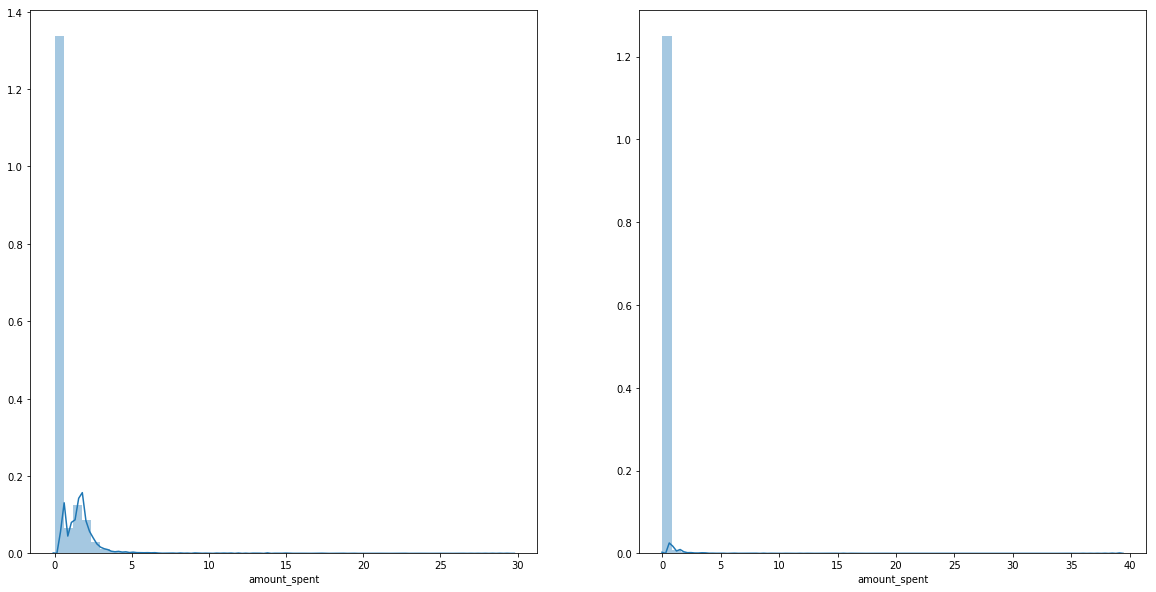

In [0]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.distplot(oof1_df2['amount_spent']*70)

plt.subplot(1, 2, 2)
sns.distplot(train_label['amount_spent'])

plt.show()

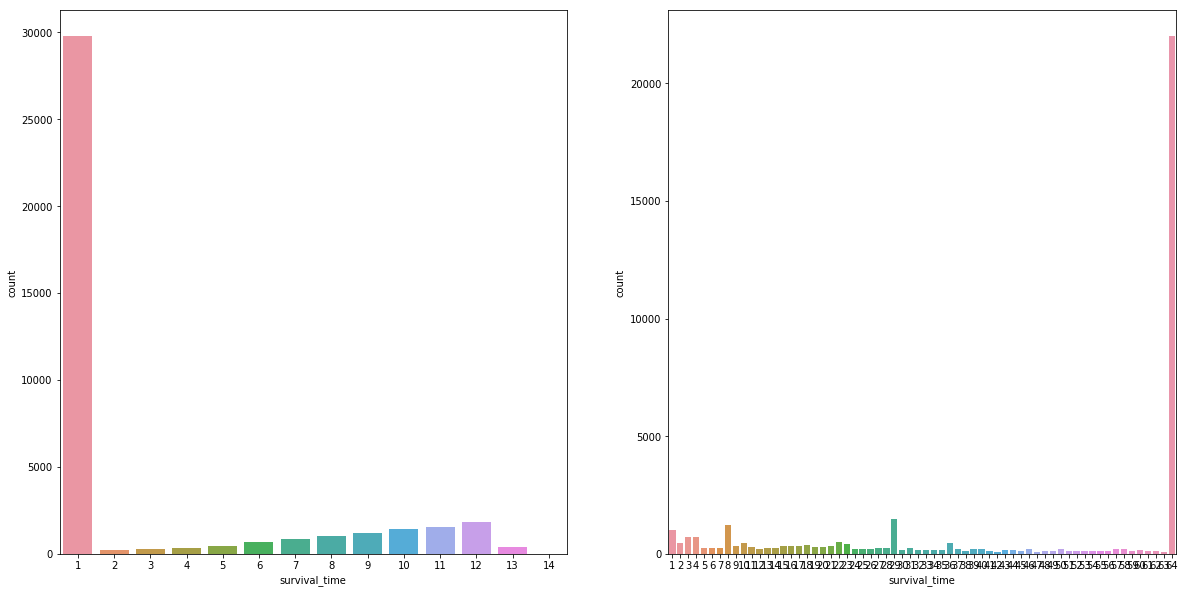

In [0]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.countplot(oof1_df2['survival_time'])

plt.subplot(1, 2, 2)
sns.countplot(train_label['survival_time'])

plt.show()

In [0]:
# score_function.score_function(train_label, train_label, path=False)
score_function(train_label, train_label)

91693.76240883442

In [0]:
pred1_df = pd.DataFrame([char_ids_t1['acc_id'], pred1_time.astype(int), pred1_spent]).T
pred1_df.columns = ['acc_id', 'survival_time', 'amount_spent']
pred1_df.head()

,acc_id,survival_time,amount_spent
0,7.0,25.0,0.227720
3,15.0,45.0,0.030262
7,16.0,62.0,0.029193
9,18.0,35.0,0.100036
11,19.0,55.0,0.033825


In [0]:
pred1_df.loc[pred1_df['survival_time'].isnull(), 'survival_time'] = pred1_df.loc[pred1_df['survival_time'].isnull(), 'survival_time'].fillna(1)
pred1_df.loc[pred1_df['survival_time']<1, 'survival_time'] = 1

In [0]:
pred1_df.loc[pred1_df['amount_spent'].isnull(), 'amount_spent'] = pred1_df.loc[pred1_df['amount_spent'].isnull(), 'amount_spent'].fillna(0)
pred1_df.loc[pred1_df['amount_spent']<0, 'amount_spent'] = 0

In [0]:
pred1_df[['acc_id', 'survival_time']] = pred1_df[['acc_id', 'survival_time']].astype(int)

In [0]:
pred1_df.to_csv('./My Drive/bigcontest2019/scripts/model/HH/0826/test1_predict_acc.csv', index=False, encoding='utf-8')

In [0]:
pred1_df.head()

,acc_id,survival_time,amount_spent
0,7,25,0.227720
3,15,45,0.030262
7,16,62,0.029193
9,18,35,0.100036
11,19,55,0.033825


In [0]:
pred1_spent.max(), pred1_spent.min(), pred1_time.max(), pred1_time.min()

(1.9406205595010393,
 -0.018661389869279333,
 72.10583810788944,
 -4.349730104958155)

In [0]:
!ls

'My Drive'  'Shared drives'


In [0]:
#os.chdir('./drive')



유형 | 점수 |
---- | ---- |
W + D| 2798.97|
W    | 2807.73|
D    | 2802.8 |
# 결과리포트